In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
activity_name = ['climbing', 'diving', 'fishing', 'racing', 'throwing', 'vaulting']

train_dir = './data/train'
test_dir = './data/test'

train_image_paths = []
train_image_labels = []

for filename in os.listdir(train_dir):
    image_path = os.path.join(train_dir, filename)
    label = filename.split('_')[0]

    train_image_paths.append(image_path)
    train_image_labels.append(label)

test_image_paths = []
test_image_labels = []

for filename in os.listdir(test_dir):
    image_path = os.path.join(test_dir, filename)
    label = filename.split('_')[0]

    test_image_paths.append(image_path)
    test_image_labels.append(label)

In [3]:
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.404], std=[0.229, 0.224, 0.225])
])

In [4]:
label_mapping = {
    'climbing': 0,
    'diving': 1,
    'fishing': 2,
    'racing': 3,
    'throwing': 4,
    'vaulting': 5
}

def normalize_label(label):
    if label == 'pole vaulting':
        return 'vaulting'
    return label

class BAR_Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        normalized_label = normalize_label(label)
        numeric_label = label_mapping[normalized_label]
        return image, torch.tensor(numeric_label)

In [5]:
train_dataset = BAR_Dataset(train_image_paths, train_image_labels, transform=transformer)
test_dataset = BAR_Dataset(test_image_paths, test_image_labels, transform=transformer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(train_loader))

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.dropout = nn.Dropout(0.5)

        self.flattened_size = self._get_flattened_size()

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 6)

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 224, 224)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = self.pool(F.relu(self.conv4(x)))
            x = F.relu(self.conv5(x))
            x = F.relu(self.conv6(x))
            return x.numel()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [8]:
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}")


Epoch [1/100], Train Loss: 1.8000
Epoch [2/100], Train Loss: 1.7983
Epoch [3/100], Train Loss: 1.7966
Epoch [4/100], Train Loss: 1.7949
Epoch [5/100], Train Loss: 1.7934
Epoch [6/100], Train Loss: 1.7917
Epoch [7/100], Train Loss: 1.7902
Epoch [8/100], Train Loss: 1.7887
Epoch [9/100], Train Loss: 1.7872
Epoch [10/100], Train Loss: 1.7859
Epoch [11/100], Train Loss: 1.7845
Epoch [12/100], Train Loss: 1.7832
Epoch [13/100], Train Loss: 1.7819
Epoch [14/100], Train Loss: 1.7806
Epoch [15/100], Train Loss: 1.7794
Epoch [16/100], Train Loss: 1.7782
Epoch [17/100], Train Loss: 1.7772
Epoch [18/100], Train Loss: 1.7761
Epoch [19/100], Train Loss: 1.7750
Epoch [20/100], Train Loss: 1.7739
Epoch [21/100], Train Loss: 1.7728
Epoch [22/100], Train Loss: 1.7715
Epoch [23/100], Train Loss: 1.7705
Epoch [24/100], Train Loss: 1.7699
Epoch [25/100], Train Loss: 1.7688
Epoch [26/100], Train Loss: 1.7680
Epoch [27/100], Train Loss: 1.7670
Epoch [28/100], Train Loss: 1.7659
Epoch [29/100], Train Loss: 1

Loss = `[1.8, 1.7983, 1.7966, 1.7949, 1.7934, 1.7917, 1.7902, 1.7887, 1.7872, 1.7859, 1.7845, 1.7832, 1.7819, 1.7806, 1.7794, 1.7782, 1.7772, 1.7761, 1.775, 1.7739, 1.7728, 1.7715, 1.7705, 1.7699, 1.7688, 1.768, 1.767, 1.7659, 1.7652, 1.7646, 1.7638, 1.7631, 1.7622, 1.7616, 1.761, 1.7601, 1.7593, 1.7586, 1.7579, 1.7571, 1.7568, 1.7562, 1.7553, 1.755, 1.7548, 1.7541, 1.7531, 1.7528, 1.7523, 1.7522, 1.7511, 1.7507, 1.75, 1.7497, 1.7492, 1.749, 1.7488, 1.7481, 1.7477, 1.7476, 1.7467, 1.7467, 1.7455, 1.7453, 1.7453, 1.7449, 1.7443, 1.7444, 1.7439, 1.7437, 1.7427, 1.7432, 1.7425, 1.7424, 1.7414, 1.7413, 1.7411, 1.7405, 1.7403, 1.7398, 1.7385, 1.7391, 1.7374, 1.7383, 1.7377, 1.7363, 1.7362, 1.7361, 1.735, 1.7342, 1.7329, 1.7322, 1.7315, 1.7296, 1.7291, 1.7281, 1.7252, 1.7236, 1.722, 1.7179]`

In [9]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Test Loss: 1.7518, Test Accuracy: 24.31%


In [10]:
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer = dict([*model.named_modules()])[target_layer_name]
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        heatmap = torch.sum(weights * self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap -= heatmap.min()
        heatmap /= heatmap.max()
        return heatmap.cpu().detach().numpy()

def overlay_heatmap(heatmap, image_path, alpha=0.5):
    original_image = Image.open(image_path).convert("RGB")
    heatmap_resized = Image.fromarray(np.uint8(heatmap * 255)).resize(original_image.size, Image.BILINEAR)

    heatmap_colored = plt.cm.jet(np.array(heatmap_resized) / 255.0)[:, :, :3] * 255
    heatmap_colored = Image.fromarray(np.uint8(heatmap_colored))

    overlayed_image = Image.blend(original_image, heatmap_colored, alpha=alpha)
    return overlayed_image


In [11]:
def generate_and_visualize_heatmap(image_path, model, target_layer_name, class_idx=None):
    model.eval()

    transformer = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.404], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transformer(image).unsqueeze(0).to(device)

    grad_cam = GradCAM(model, target_layer_name)

    outputs = model(input_tensor)
    if class_idx is None:
        class_idx = torch.argmax(outputs, dim=1).item()

    model.zero_grad()
    outputs[0, class_idx].backward()

    heatmap = grad_cam.generate_heatmap(class_idx)

    overlayed_image = overlay_heatmap(heatmap, image_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Heat Map Overlay")
    plt.imshow(overlayed_image)
    plt.axis("off")
    plt.show()

/Users/anmolrao/Code/SiFeR/sifer_venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


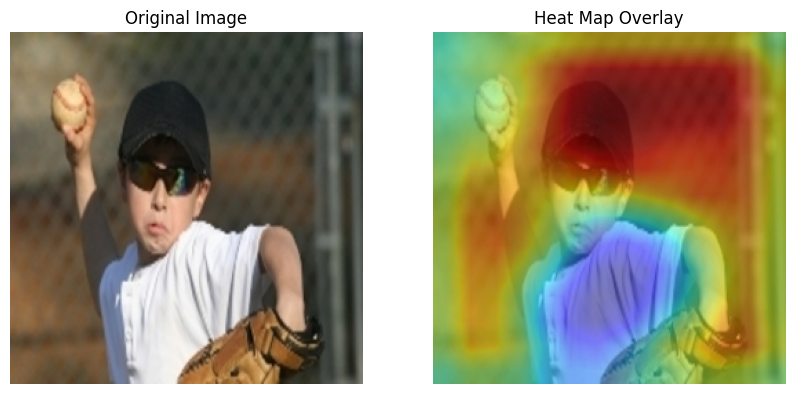

In [12]:
image_path = './data/test/throwing_321.jpg'
target_layer_name = 'conv6'
generate_and_visualize_heatmap(image_path, model, target_layer_name)